# RTL-SDR Ultrasound Test
Copyright (C) 2018 William Meng

This file is part of rtl_ultrasound

rtl_ultrasound is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

rtl_ultrasound is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with rtl_ultrasound.  If not, see <http://www.gnu.org/licenses/>.

-------
William Meng K9TTL  
Aug 13, 2018

In this notebook, I will demonstrate how to:
* use pyrtlsdr to receive IQ samples of ultrasound data
* extract the envelope of the ultrasound signal
* approximately reconstruct the original ultrasound signal (albeit with different initial phase)
* slice the scanlines according to a trigger threshold and holdoff time
* plot a 2D image

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from rtlsdr import *
from scipy.signal import resample
from scipy.signal import hilbert
import time
from datetime import datetime
%matplotlib inline

## Configure settings for RTL-SDR

In [2]:
sdr = RtlSdr()

# configure device
sdr.set_direct_sampling(2) # directly sample Q channel
sdr.center_freq = 8e6
sdr.sample_rate = 2.4e6
sdr.gain = 'auto'

center_freq = sdr.center_freq
sample_rate = sdr.sample_rate
print("center freq = {} Hz".format(center_freq))
print("sample rate = {} Hz".format(sample_rate))
print("gain = {}".format(sdr.gain))

center freq = 8000000 Hz
sample rate = 2400000.0 Hz
gain = 0.0


## Acquire data and save to file

In [3]:
# read samples
samples = sdr.read_samples(256*512)
sdr.close()

# save samples to disk with timestamp
timestamp = datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d_%H:%M:%S')
np.save("rtlsdr_ultrasound_test_{}".format(timestamp), samples)

## Load data from file and plot

[-0.00392157+0.00392157j  0.00392157+0.00392157j -0.00392157-0.00392157j
 ...,  0.00392157+0.00392157j  0.00392157+0.00392157j
 -0.00392157+0.00392157j]
Found 131072 samples


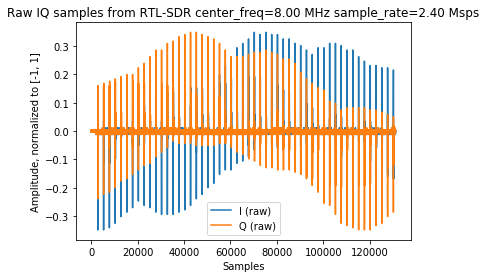

CPU times: user 737 ms, sys: 36 ms, total: 773 ms
Wall time: 855 ms


In [21]:
%%time
samples = np.load("rtlsdr_ultrasound_test_2018-08-13_13:16:29.npy")
print(samples)
print("Found {} samples".format(len(samples)))
I_raw = np.real(samples)
Q_raw = np.imag(samples)
plt.plot(I_raw, label="I (raw)")
plt.plot(Q_raw, label="Q (raw)")
plt.title("Raw IQ samples from RTL-SDR center_freq=%.2f MHz sample_rate=%.2f Msps" % (center_freq/1e6, sample_rate/1e6))
plt.xlabel("Samples")
plt.ylabel("Amplitude, normalized to [-1, 1]")
plt.legend()
plt.show()

## Process signal
### Upsample and generate time base

In [5]:
%%time
upsampling_factor = 10
resampled = resample(samples, len(samples) * upsampling_factor)
fs = sample_rate * upsampling_factor
Ts = 1e6/fs # time per sample after resampling, in microseconds
print("Resampled at:")
print("fs = %.2f Msps" % (fs/1e6))
print("Ts = {} microseconds".format(Ts))
t = np.array([ x * Ts for x in range(len(resampled))]) # time base, in microseconds

Resampled at:
fs = 24.00 Msps
Ts = 0.041666666666666664 microseconds
CPU times: user 382 ms, sys: 88.1 ms, total: 471 ms
Wall time: 511 ms


### Plot envelope

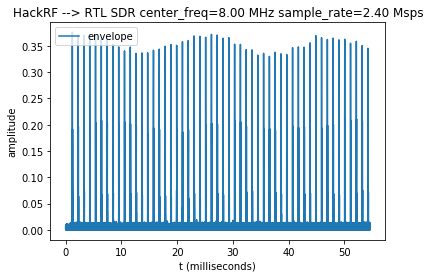

CPU times: user 3.43 s, sys: 166 ms, total: 3.59 s
Wall time: 3.98 s


In [6]:
%%time
envelope = np.abs(resampled)
t_ms = t/1000
plt.plot(t_ms, envelope, label="envelope")
plt.xlabel('t (milliseconds)')
plt.ylabel('amplitude')
plt.title("HackRF --> RTL SDR center_freq=%.2f MHz sample_rate=%.2f Msps" %
          (center_freq/1.0e6, sample_rate/1.0e6))
plt.legend()
plt.show()

*[Let's enhance](https://www.youtube.com/watch?v=LhF_56SxrGk) the image...*

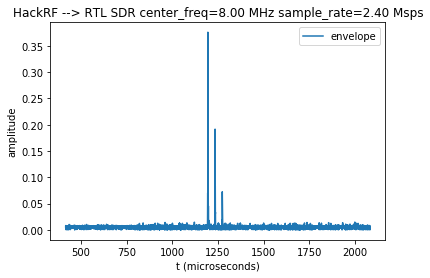

CPU times: user 229 ms, sys: 13.5 ms, total: 243 ms
Wall time: 296 ms


In [7]:
%%time
start = 10000
end = 50000
zoomed_envelope = envelope[start:end]
zoomed_t = t[start:end]
plt.plot(zoomed_t, zoomed_envelope, label="envelope")
plt.xlabel('t (microseconds)')
plt.ylabel('amplitude')
plt.title("HackRF --> RTL SDR center_freq=%.2f MHz sample_rate=%.2f Msps" %
          (center_freq/1.0e6, sample_rate/1.0e6))
plt.legend()
plt.show()

*What's that over there? Zoom and enhance.*

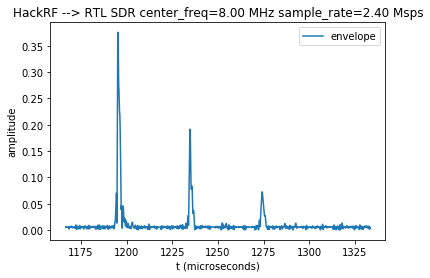

CPU times: user 198 ms, sys: 10.4 ms, total: 209 ms
Wall time: 222 ms


In [8]:
%%time
start1 = 28000
end1 = 32000
megazoomed_envelope = envelope[start1:end1]
megazoomed_t = t[start1:end1]
plt.plot(megazoomed_t, megazoomed_envelope, label="envelope")
plt.xlabel('t (microseconds)')
plt.ylabel('amplitude')
plt.title("HackRF --> RTL SDR center_freq=%.2f MHz sample_rate=%.2f Msps" %
          (center_freq/1.0e6, sample_rate/1.0e6))
plt.legend()
plt.show()

~~Look over there, it's a corneal reflection!~~

We have an envelope signal that corresponds nicely to the original data from kelu124:  
![example data from un0rick](https://raw.githubusercontent.com/kelu124/un0rick/master/images/20180403/p_A-130us-0-VGA%400x22-spimode1-64msps.jpg)

## Approximate reconstruction of original ultrasound signal

~~Extract vector a6 and use it to reconstruct the face...~~

Just kidding, you can't just magically reconstruct a real signal... you also need the imaginary part!

We can construct an RF signal from IQ samples by modulating a cosine and sine at the carrier frequency by I and Q, respectively, then subtracting the results.

$ r(t) = I(t) \cos(2\pi f_c t) - Q(t) \sin(2\pi f_c t)$, 
where $f_c$ is the carrier frequency

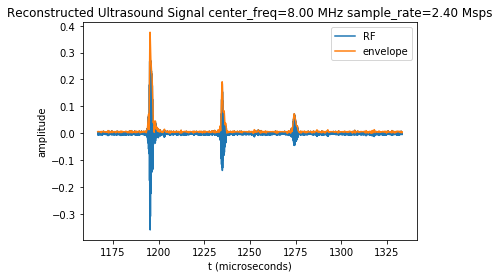

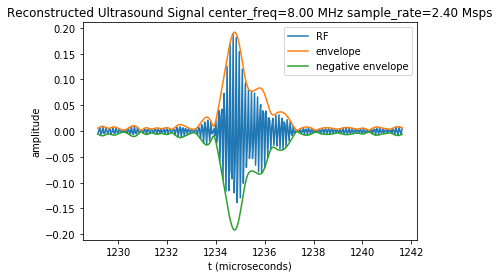

CPU times: user 492 ms, sys: 27 ms, total: 519 ms
Wall time: 534 ms


In [9]:
%%time
megazoomed_data = resampled[start1:end1]
I = np.real(megazoomed_data) # In-phase modulating signal
Q = np.imag(megazoomed_data) # Quadrature-phase modulating signal
LO_cos = np.cos(2.0*np.pi*center_freq*megazoomed_t) # Local Oscillator, cos
LO_sin = np.sin(2.0*np.pi*center_freq*megazoomed_t) # Local Oscillator, sin
RF = I*LO_cos - Q*LO_sin # reconstructed RF signal

plt.plot(megazoomed_t, RF, label="RF")
plt.plot(megazoomed_t, megazoomed_envelope, label="envelope")
plt.xlabel('t (microseconds)')
plt.ylabel('amplitude')
plt.title("Reconstructed Ultrasound Signal center_freq=%.2f MHz sample_rate=%.2f Msps" %
          (center_freq/1.0e6, sample_rate/1.0e6))
plt.legend()
plt.show()

# zoom in on RF signal
start2 = 1500
end2 = 1800
zoomed_RF = RF[start2:end2]
plt.plot(megazoomed_t[start2:end2], zoomed_RF, label="RF")
plt.plot(megazoomed_t[start2:end2], megazoomed_envelope[start2:end2], label="envelope")
plt.plot(megazoomed_t[start2:end2], -megazoomed_envelope[start2:end2], label="negative envelope")
plt.xlabel('t (microseconds)')
plt.ylabel('amplitude')
plt.title("Reconstructed Ultrasound Signal center_freq=%.2f MHz sample_rate=%.2f Msps" %
          (center_freq/1.0e6, sample_rate/1.0e6))
plt.legend()
plt.show()

There's no guarantee that LO_cos and LO_sin have an intial phase matching the ultrasound signal's initial phase.
Also, there's no guarantee that the LO frequency is exactly equal to ultrasound signal's frequency
(which should equal the resonant frequency of the piezo transducer).
The IQ samples only describe how the RF signal is modulated, and convey no information whatsoever about the carrier signal.

However, this is still a good way to approximately visualize the relation of the envelope signal to the original ultrasound signal.

## Construct image

To construct a 2D ultrasound image, we need to slice the 1D ultrasound signal into individual scan lines.
This can be done by setting a an appropriate threhold amplitude for identifying a trigger pulse,
and the minimum time for a scan line so as to prevent slicing the signal in the middle of a scan line.
This is exactly analogous to the trigger level and trigger holdoff settings on an oscilloscope.

### Set trigger level and holdoff

max(envelope) = 0.37580465651100414
Trigger level = 0.30064372520880334


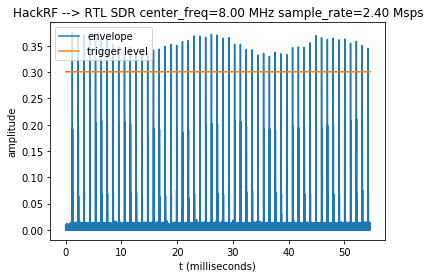

CPU times: user 6.28 s, sys: 335 ms, total: 6.62 s
Wall time: 6.9 s


In [10]:
%%time
max_envelope = np.max(envelope)
print("max(envelope) = {}".format(max_envelope))
trigger_level = 0.8 * max_envelope
print("Trigger level = {}".format(trigger_level))

plt.plot(t_ms, envelope, label="envelope")
plt.plot(t_ms, [trigger_level] * len(t_ms), label="trigger level")
plt.xlabel('t (milliseconds)')
plt.ylabel('amplitude')
plt.title("HackRF --> RTL SDR center_freq=%.2f MHz sample_rate=%.2f Msps" %
          (center_freq/1.0e6, sample_rate/1.0e6))
plt.legend()
plt.show()

In [11]:
%%time
trigger_holdoff_us = 130 # trigger holdoff time in microseconds
trigger_holdoff = int(trigger_holdoff_us / Ts) # trigger holdoff in # of samples
print("Trigger holdoff = {} microseconds = {} samples".format(trigger_holdoff_us, trigger_holdoff))

Trigger holdoff = 130 microseconds = 3120 samples
CPU times: user 270 µs, sys: 95 µs, total: 365 µs
Wall time: 327 µs


### Slice into scan lines
Now let's iteratively identify the slicing points, and plot the first few.

Slicing at indices [28683, 53643, 78603, 103563, 128523, 153483, 178443, 203404, 228364, 253324, 278284, 303245, 328205, 353165, 378125, 403085, 428046, 453005, 477966, 502926, 527886, 552845, 577805, 602765, 627725, 652685, 677645, 702606, 727566, 752526, 777486, 802446, 827407, 852367, 877327, 902288, 927248, 952209, 977168, 1002128, 1027088, 1052048, 1077008, 1101968, 1126928, 1151888, 1176848, 1201808, 1226768, 1251728, 1276688, 1301649]
Triggered 52 times


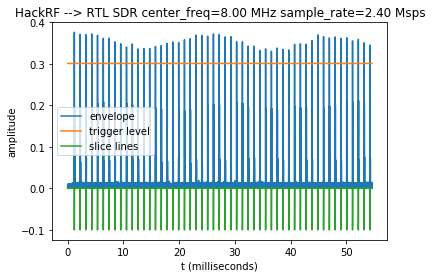

CPU times: user 10.7 s, sys: 751 ms, total: 11.4 s
Wall time: 13.3 s


In [12]:
%%time
prev_trigger = -trigger_holdoff # allow first trigger to be at 0th sample
slice_indices = list()
for i in range(len(envelope)):
    if i >= prev_trigger + trigger_holdoff:
        if envelope[i] > trigger_level:
            slice_indices.append(i)
            prev_trigger = i

print("Slicing at indices {}".format(slice_indices))
print("Triggered {} times".format(len(slice_indices)))

# Visualize where the slicing happens
slice_lines = np.zeros(len(envelope))
"""
# this is extremely slow, because the numpy array has to be copied in memory for each substitution
for i in range(len(slice_lines)):
    if i in slice_indices:
        slice_lines[i] = -0.1
"""
# faster method:
slice_lines[slice_indices] = -0.1

plt.plot(t_ms, envelope, label="envelope")
plt.plot(t_ms, [trigger_level] * len(t_ms), label="trigger level")
plt.plot(t_ms, slice_lines, label="slice lines")
plt.xlabel('t (milliseconds)')
plt.ylabel('amplitude')
plt.title("HackRF --> RTL SDR center_freq=%.2f MHz sample_rate=%.2f Msps" %
          (center_freq/1.0e6, sample_rate/1.0e6))
plt.legend()
plt.show()

Intervals between each trigger are [24960 24960 24960 24960 24960 24960 24961 24960 24960 24960 24961 24960
 24960 24960 24960 24961 24959 24961 24960 24960 24959 24960 24960 24960
 24960 24960 24961 24960 24960 24960 24960 24961 24960 24960 24961 24960
 24961 24959 24960 24960 24960 24960 24960 24960 24960 24960 24960 24960
 24960 24960 24961]
Choosing the minimum, 24959, as the length of each scan line
Not enough samples left for a complete scan line!
Created 51 scan lines


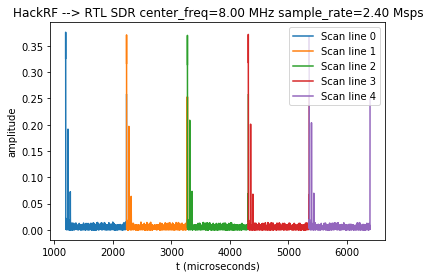

CPU times: user 558 ms, sys: 37.5 ms, total: 595 ms
Wall time: 667 ms


In [13]:
%%time
# slice array and vstack
diffs = np.diff(slice_indices)
min_diff = np.min(diffs)
print("Intervals between each trigger are {}".format(diffs))
print("Choosing the minimum, {}, as the length of each scan line".format(min_diff))

scan_lines = list()
for index in slice_indices:
    if len(envelope) < index + min_diff:
        print("Not enough samples left for a complete scan line!")
        continue
    scan_line = envelope[index:index+min_diff]
    scan_lines.append(scan_line)

print("Created {} scan lines".format(len(scan_lines)))

# Plot first 5 scan lines
for i in range(5):
    index = slice_indices[i]
    plt.plot(t[index:index+min_diff], scan_lines[i], label="Scan line {}".format(i))
 
plt.xlabel('t (microseconds)')
plt.ylabel('amplitude')
plt.title("HackRF --> RTL SDR center_freq=%.2f MHz sample_rate=%.2f Msps" %
      (center_freq/1.0e6, sample_rate/1.0e6))
plt.legend()
plt.show()

### Stack scan lines into image
Use numpy.vstack(), then (optionally) crop the 2D array to get rid of some blank space.

Image dimensions: (51, 24959)


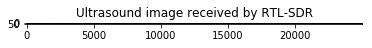

CPU times: user 180 ms, sys: 32.9 ms, total: 213 ms
Wall time: 241 ms


In [14]:
%%time
image = np.vstack(tuple(scan_lines))
print("Image dimensions: {}".format(image.shape))
plt.imshow(image, cmap='gray')
plt.title("Ultrasound image received by RTL-SDR")
plt.show()

### Crop and repeat image for easier viewing

Cropped image dimensions: (51, 3000)


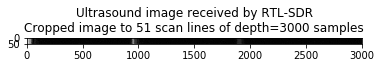

Repeated image dimensions: (3009, 3000)


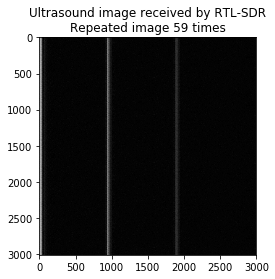

CPU times: user 637 ms, sys: 250 ms, total: 887 ms
Wall time: 980 ms


In [35]:
%%time
max_depth = 3000
image_cropped = image[:,:max_depth]
print("Cropped image dimensions: {}".format(image_cropped.shape))
plt.imshow(image_cropped, cmap='gray')
plt.title("Ultrasound image received by RTL-SDR\nCropped image to {} scan lines of depth={} samples".format(*image_cropped.shape))
plt.show()

n = 59 # number of times to repeat image
image_repeated = np.vstack(tuple([image_cropped]*n))
print("Repeated image dimensions: {}".format(image_repeated.shape))
plt.imshow(image_repeated, cmap='gray')
plt.title("Ultrasound image received by RTL-SDR\nRepeated image {} times".format(n))
plt.show()

In [40]:
# save 2D array to disk
np.save("rtlsdr_image_08-13_13:16:29.npy", image_repeated)

### Polar to Cartesian mapping

This will be useful for viewing images acquired from a B-mode ultrasound device
where the transducer angle is sweeped mechanically.

Possible methods:
* [polarTransform](https://github.com/addisonElliott/polarTransform) library - I tried this and it wasn't working for some reason (infinite loop?)
* [OpenCV linearPolar()](https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html#linearpolar)
* [scipy geometric_transform()](https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.ndimage.interpolation.geometric_transform.html)
* I stop being lazy and code it myself! 😆

In [41]:
image_repeated = np.load("rtlsdr_image_08-13_13:16:29.npy")

#### OpenCV
Documentation for:
* [cv2.linearPolar()](https://docs.opencv.org/master/da/d54/group__imgproc__transform.html#gaa38a6884ac8b6e0b9bed47939b5362f3)
* [cv2.warpPolar()](https://docs.opencv.org/master/da/d54/group__imgproc__transform.html#ga49481ab24fdaa0ffa4d3e63d14c0d5e4)

CPU times: user 250 ms, sys: 159 ms, total: 409 ms
Wall time: 389 ms


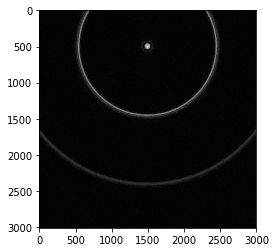

In [42]:
%%time
import cv2

center = (1500, 500)
maxRadius = 3000
flags = cv2.WARP_INVERSE_MAP
dst = cv2.linearPolar(image_repeated, center, maxRadius, flags)
plt.imshow(dst, cmap='gray')

Unfortunately, it appears that there is no way to specify bounds on theta, so `linearPolar()`
always maps the rows of the input image to the range $[0, 2\pi)$.

#### My implementation
The basic principle is as follows:
1. Figure out what polar coordinates map to the desired cartesian coordinates.
Picture generated from [mathinsight.org applet](https://mathinsight.org/polar_coordinates_mapping).
![polar2cart](polar2cart.png)
* $\theta$ is going to be a symmetric interval centered at $3\pi/2$.
The range of $\theta$ will be equal to the range of angles sweeped by the transducer.
* $r$ will range from some minimum value $r_{min}$
(determined by the distance between the transducer and axis of rotation)
to a maximum value $r_{max}$, which will determine how large the final image appears.
* We create a 2D matrix to represent the input space of the transformation, and label the axes $(r, \theta)$.
* We scale and stretch the original image (ie. vertically stacked scan lines) to fit within the 
aforementioned bounds on $r$ and $\theta$, and write this to the input space.
* We create a 2D matrix to represent the output space of the transformation. Essentially, it's blank canvas upon which to draw the final image. This can be a square image of all white pixels.
* The transformation is the mapping of polar coordinates to cartesian coordinates,
ie. $(r, \theta) \rightarrow (x, y)$. It is defined by $x = r \cos\theta$ and $y = r \sin\theta$.
The inverse transformation $(x, y) \rightarrow (r, \theta)$ is defined by 
$r = \sqrt{x^2 + y^2}$ and $\theta = \arctan(\frac{y}{x})$ + possibly $\pi/2$ or $\pi$ depending on the quadrant.
* For each pixel coordinate (x, y) in the output space, we compute the inverse transformation to get a corresponding 
coordinate in the input space. We then then fetch the value of the image at the coordinate in the input space,
and write that to the coordinate in the output space.

Issue:
* pixels with small r will get squished in the output space
* pixels with large r will get stretched in the output space

In [43]:
angle_range = np.pi/2
theta_min = 3/2*np.pi - angle_range/2
theta_max = 3/2*np.pi + angle_range/2
r_min = 0
r_max = 1000
print("theta: [{}, {}] radians".format(theta_min, theta_max))
print("r: [{}, {}]".format(r_min, r_max))

theta: [3.9269908169872414, 5.497787143782138] radians
r: [0, 1000]


In [56]:
def output_space(row, col, im_out_shape):
    """ Map pixels in output image to cartesian coordinates """
    x = (col - im_out_shape[1])
    y = (im_out_shape[0] - row)
    return x, y
    
def get_pixel_from_input_space(r, theta, r_min, r_max, theta_min, theta_max, im_in):
    """ Map (r, theta) to pixels in the input image """
    if r < r_min or r > r_max or theta < theta_min or theta > theta_max:
        return None
    # shift, then scale
    row_range = im_in.shape[0]
    col_range = im_in.shape[1]
    row = (theta - theta_min)*row_range/(theta_max - theta_min)
    col = (r - r_min)*col_range/(r_max - r_min)
    # get pixel value
    value = im_in[int(row), int(col)]
    return value

Dimensions of output image: 1000 rows 2000 cols


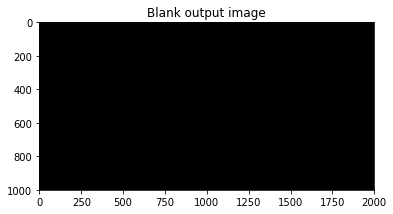

ValueError: setting an array element with a sequence.

<Figure size 432x288 with 1 Axes>

In [75]:
import math
import warnings

warnings.simplefilter('error', UserWarning)

im_out_dimen = (1000, 2000)
im_out = np.zeros(im_out_dimen, dtype='float')
print("Dimensions of output image: {} rows {} cols".format(*im_out.shape))

plt.imshow(im_out, cmap='gray')
plt.title("Blank output image")
plt.show()

#for row, col in np.ndindex(im_out.shape):
#for row, col in zip(range(im_out.shape[0]), range(im_out.shape[1])):
for row in range(im_out.shape[0]):
    for col in range(im_out.shape[1]):
        x, y = output_space(row, col, im_out.shape)
        r = math.sqrt(x**2 + y**2)
        theta = None
        if x < 0: # quadrant II or III
            theta = math.atan(y/x) + np.pi
        elif x == 0: # avoid division by zero
            r = -y
            theta = 3/2*np.pi
        elif y < 0: # quadrant IV
            theta = math.atan(y/x) + 2*np.pi
        value = get_pixel_from_input_space(r, theta, r_min, r_max, theta_min, theta_max, image_repeated)
        im_out[row, col] = value
    
plt.imshow(im_out, cmap='gray')
plt.title("Rendered output image")
plt.show()

Oops, I've created quite the mess.

#### OpenCV revisisted
I think an easier way to solve the problem is to resize, scale, and pad the input image as necessary,
so the output image will appear as though it has to correct bounds on $\theta$.
In actuality, any pixel outside of the desired range of theta will be set to be black.

How to process image:
* crop image to discard data beyond max radius
* map rows of rectangular image to desired $\theta$ range
* create new empty rows to pad image so its $\theta \in [0, 2\pi)$
* stretch image to be square
* choose center point to be top and center
* linearPolar()

Image from [OpenCV documentation](https://docs.opencv.org/master/da/d54/group__imgproc__transform.html#ga49481ab24fdaa0ffa4d3e63d14c0d5e4)
that shows sign conventions for $(r, \theta)$ and $(x, y)$:
![opencv_polar_remap](https://docs.opencv.org/master/polar_remap_doc.png)

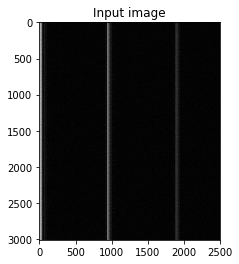

1915.5888950540523 rows per radian
theta: [3.9269908169872414, 5.497787143782138] radians
Padding 1504 above and 7522 below


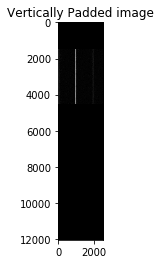

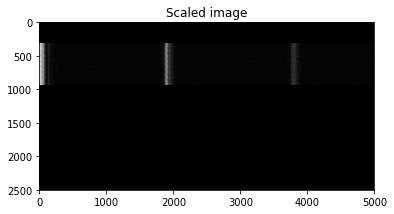

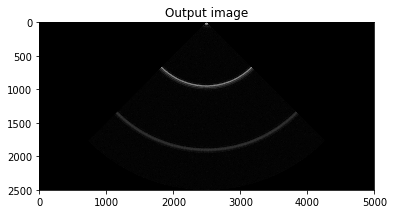

CPU times: user 3.39 s, sys: 1.88 s, total: 5.27 s
Wall time: 6 s


In [105]:
%%time
import cv2

maxRadius = 2500
im_in = image_repeated[:, :maxRadius] # cut off any data beyond maxRadius
plt.imshow(im_in, cmap='gray')
plt.title("Input image")
plt.show()

angle_range = np.pi/2 # range of angle swept by transducer (radians)
theta_scale_factor = image_repeated.shape[0] / angle_range # rows per radian
print("{} rows per radian".format(theta_scale_factor))
theta_min = 3/2*np.pi - angle_range/2
theta_max = 3/2*np.pi + angle_range/2
print("theta: [{}, {}] radians".format(theta_min, theta_max))

# pad the image
pad_below = int(theta_min * theta_scale_factor) # how many rows to pad below theta_min
pad_above = int((2*np.pi - theta_max) * theta_scale_factor) # how mahy rows to pad above theta_max
print("Padding {} above and {} below".format(pad_above, pad_below))
im_below = np.zeros((pad_below, maxRadius))
im_above = np.zeros((pad_above, maxRadius))

padded_image = np.vstack((im_above, im_in, im_below))
plt.imshow(padded_image, cmap='gray')
plt.title("Vertically Padded image")
plt.show()

# scale image
scaled_image = cv2.resize(padded_image, (2*maxRadius, maxRadius), interpolation=cv2.INTER_CUBIC)
plt.imshow(scaled_image, cmap='gray')
plt.title("Scaled image")
plt.show()

# transform image
center = (int(im_out.shape[1]/2), 0) # (x, y) coordinate from top-left of image
flags = cv2.WARP_INVERSE_MAP
im_out = cv2.linearPolar(scaled_image, center, maxRadius, flags)
plt.imshow(im_out, cmap='gray')
plt.title("Output image")
plt.show()

TODO:
* create mask so the image looks prettier
* horizontally pad on the left according to $r_{min}$

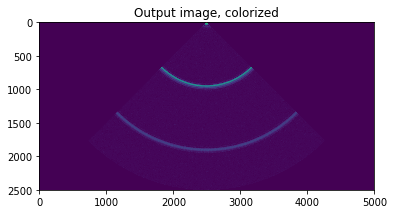

In [106]:
plt.imshow(im_out)
plt.title("Output image, colorized")
plt.show()

In [108]:
# save 2D array of polar2cart image to disk
np.save("rtlsdr_polar2cart_08-13_13:16:29.npy", im_out)
# warning: this file is quite large! ~95MB